In [1]:
import numpy as np
from nbodykit.lab import *
from nbodykit.transform import CartesianToEquatorial
import healpy as hp
import h5py 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

root = 0
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

In [2]:
# general plot params
params = {'legend.fontsize': 18,
          'legend.handlelength': 2,
          'axes.titlesize' : 24,
          'axes.labelsize' : 24,
          'axes.formatter.use_mathtext' : True,   #ensures ticks follow math format. actually this doesn't work. We'll doit another time
          'xtick.labelsize' : 16,
          'ytick.labelsize' : 16,
          'font.family' : 'serif',
          #'font.serif' : 'cm',
          #'text.usetex' : True,
          'mathtext.fontset' : 'cm',
          'savefig.format' : 'pdf',
         }
plt.rcParams.update(params)

# 2d test. Jump to below for 3d

In [ ]:
sim = 'rfof_proc64_nc512_size5000_nsteps60lin_ldr0_rcvfalse_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_2048_rfofkdt_8/'
prtl = BigFileCatalog(f'/global/cfs/cdirs/m3035/abayer/halfdome/ics/low_res/{sim}/usmesh', dataset='1')

In [3]:
# obtain real field
mesh_name = f'/global/cfs/cdirs/m3035/abayer/halfdome/ics/low_res/{sim}'
mesh_k = BigFileMesh(mesh_name+'lineark/', dataset='LinearDensityK', comm=comm)
mesh_kr = mesh_k.compute(mode='real')

In [4]:
delta = mesh_kr[::2,::2,::2].flatten()  # unroll deltas, and subsample x2 from force grid

In [4]:
np.max(prtl["ID"]).compute() + 1, delta.shape  # IDs size should be same as subsampled force grid

/usr/local/lib/python3.10/dist-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


(134217728, (134217728,))

In [5]:
def read_range(cat, amin, amax):  # Yici gave this to me
    """ Read a portion of the lightcone between two red shift ranges
        The lightcone from FastPM is sorted in Aemit and an index is built.
        So we make use of that.
        CrowCanyon is z > 0; We paste the mirror image to form a full sky.
    """
    edges = cat.attrs['aemitIndex.edges']
    offsets = cat.attrs['aemitIndex.offset']
    start, end = edges.searchsorted([amin, amax])
    if cat.comm.rank == 0:
        cat.logger.info("Range of index is %d to %d" %(( start + 1, end + 1)))
    start = offsets[start + 1]
    end = offsets[end + 1]
    cat =  cat.query_range(start, end)
    #cat1 = cat.copy()
    #cat1['Position'] = cat1['Position'] * [1, 1, -1.]
    #cat3 = ConcatenateSources(cat, cat1)
    if cat.csize > 0:
        cat['RA'], cat['DEC'] = CartesianToEquatorial(cat['Position'], frame='galactic')
    else:
        cat['RA'] = 0
        cat['DEC'] = 0
    return cat  # returns RA, DEC in degrees

In [6]:
# get particle locations
amin, amax = 0.45, 0.55
cat = read_range(prtl, amin, amax)
nside = 128
npix = hp.nside2npix(nside)
hp_ind = hp.ang2pix(nside, cat["RA"], cat["DEC"], lonlat=True).compute()

In [7]:
# get deltas based on particle ID
delta_at_particle = delta[np.array(cat['ID'])]

# set up some arrays for maps
particlemap, densitymap = np.zeros(npix), np.zeros(npix)

# add at pixel locations
np.add.at(particlemap, hp_ind, 1)
np.add.at(densitymap, hp_ind, delta_at_particle)

# normalize
particlemap = particlemap / np.mean(particlemap) - 1
densitymap = densitymap / np.mean(densitymap) - 1

/usr/local/lib/python3.10/dist-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [8]:
np.sum(delta_at_particle) / len(cat["RA"])  # deltas are mean 1

1.0005216578729783

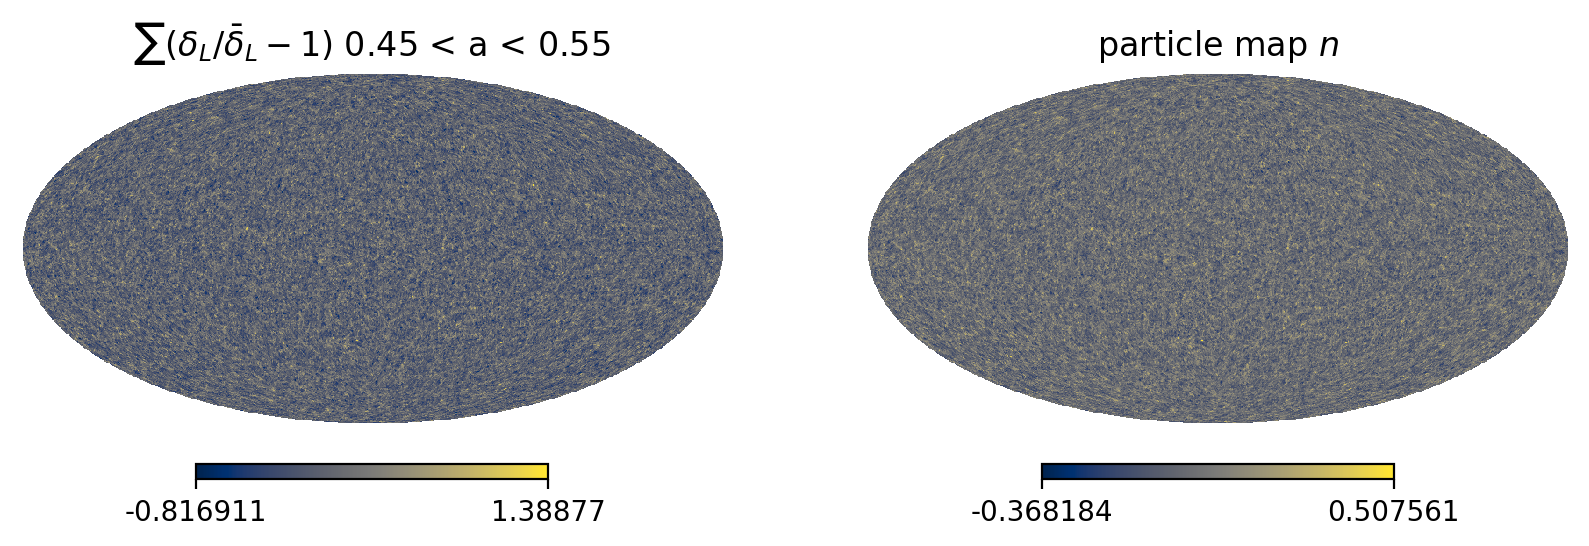

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.sca(ax[0])
hp.mollview(densitymap, cmap="cividis", hold=True,
            title=r"$\sum (\delta_L / \bar{\delta}_L-1)$ " + f"{amin} < a < {amax}")
plt.sca(ax[1])
hp.mollview(particlemap, cmap="cividis", hold=True,
            title="particle map $n$")

Text(0.5, 0, 'Multipole moment, $\\ell$')

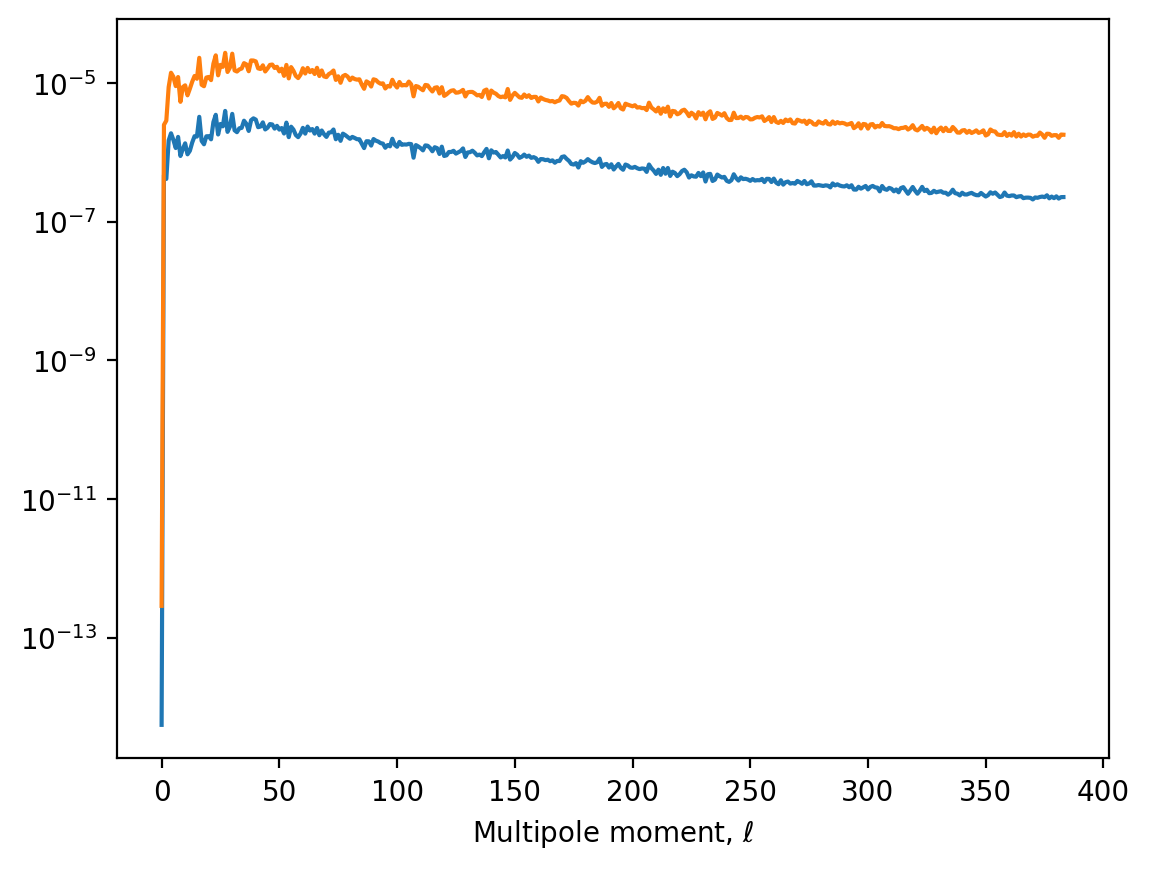

In [10]:
alm_particles = hp.map2alm(particlemap)
alm_density = hp.map2alm(densitymap)

plt.plot(hp.alm2cl(alm_particles), label="Auto-spectrum of particles, $n$")
plt.plot(hp.alm2cl(alm_density), label=r"Auto-spectrum $(\rho / \bar{\rho}-1)$ at particle locations")
# plt.plot(hp.alm2cl(alm_particles, alm_density), label=r"Cross-spectrum $n$ and $(\rho / \bar{\rho}-1)$")
plt.yscale("log"); plt.xlabel("Multipole moment, $\ell$")

Text(0.5, 0, 'Multipole moment, $\\ell$')

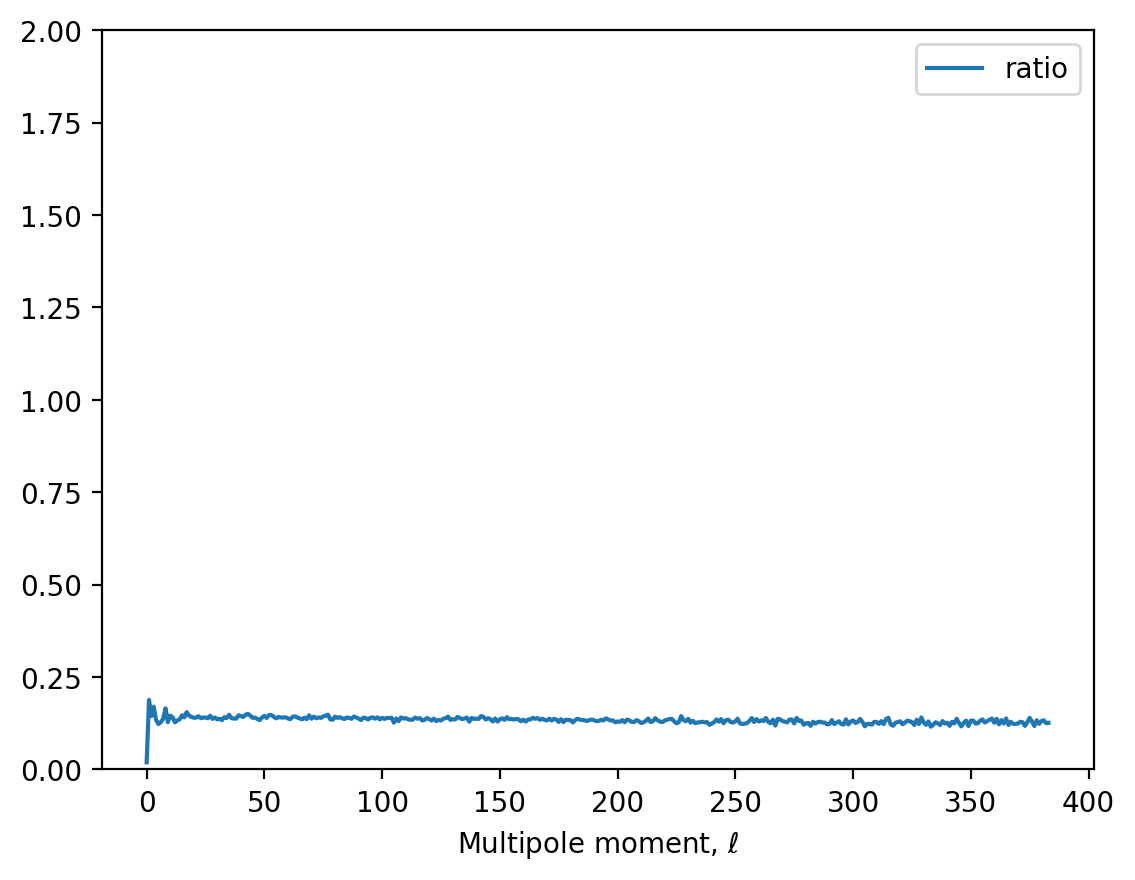

In [11]:
plt.plot(hp.alm2cl(alm_particles) / hp.alm2cl(alm_density), label="ratio")
plt.legend(); plt.ylim(0,2); plt.xlabel("Multipole moment, $\ell$")

/usr/local/lib/python3.10/dist-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/usr/local/lib/python3.10/dist-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/usr/local/lib/python3.10/dist-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/usr/local/lib/python3.10/dist-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or

Text(0.5, 0, 'Multipole moment, $\\ell$')

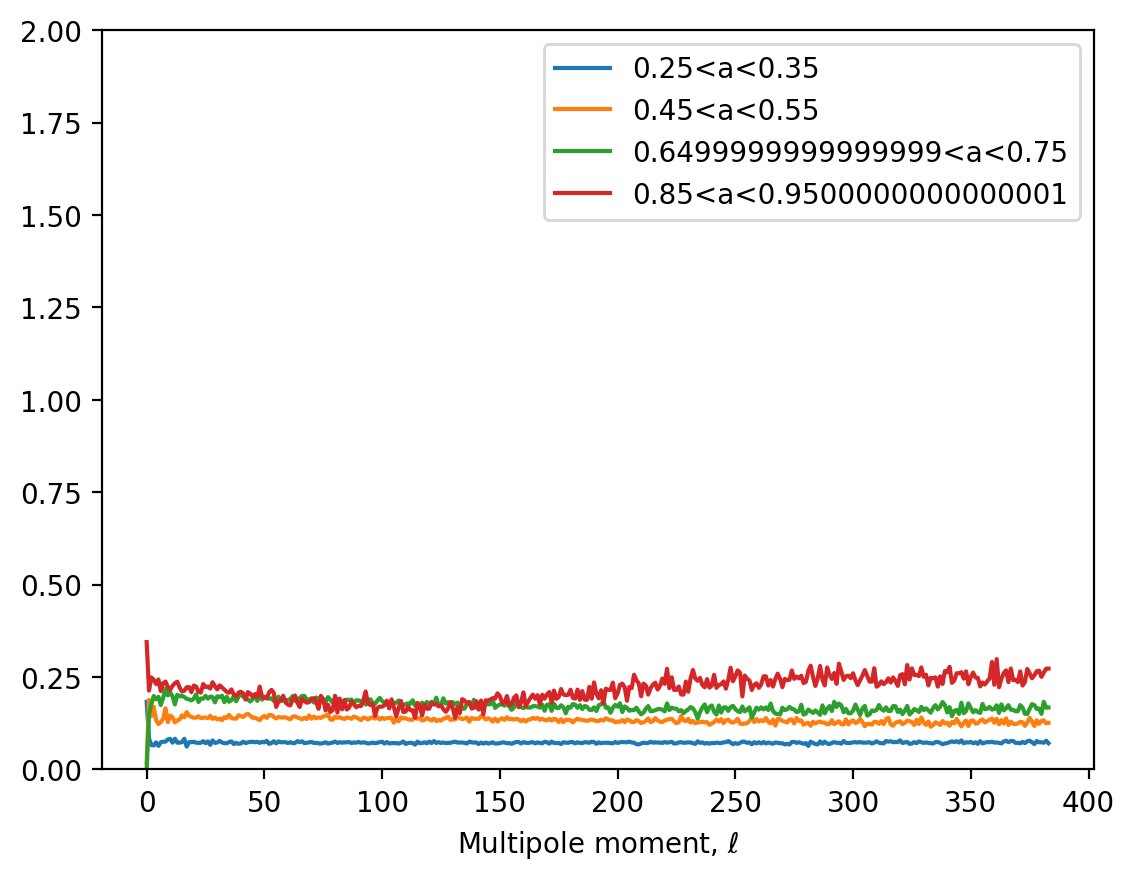

In [12]:
for a in (0.3, 0.5, 0.7, 0.9):
    amin, amax = a - 0.05, a + 0.05
    cat = read_range(prtl, amin, amax)
    hp_ind = hp.ang2pix(nside, cat["RA"], cat["DEC"], lonlat=True).compute()
    delta_at_particle = delta[np.array(cat['ID'])]
    particlemap, densitymap, shuffledensitymap = np.zeros(npix), np.zeros(npix), np.zeros(npix)
    np.add.at(particlemap, hp_ind, 1)
    np.add.at(densitymap, hp_ind, delta_at_particle)
    particlemap = particlemap / np.mean(particlemap) - 1
    densitymap = densitymap / np.mean(densitymap) - 1
    alm_particles = hp.map2alm(particlemap)
    alm_density = hp.map2alm(densitymap)
    plt.plot(hp.alm2cl(alm_particles) / hp.alm2cl(alm_density), label=f"{amin}<a<{amax}")
plt.legend(); plt.ylim(0,2); plt.xlabel("Multipole moment, $\ell$")

# 3d test (start from scratch, reload everything to avoid bugs)

In [3]:
mother = '/global/cfs/cdirs/mp107d/exgal/users/abayer/halfdome/ics/low_res/'

from colossus.cosmology import cosmology as colossus_cosmology
OmegaB = 0.0486 #0.046
OmegaM = 0.3089 #0.309167
OmegaC = OmegaM-OmegaB

h=0.6774
H0 = h*100
sigma8 = 0.8159
n_s = 0.9667 #the tilt of the primordial power spectrum
#As = 2e-09 * (sigma8/0.80258204)**2
params = {'flat': True, 'H0': H0, 'Om0': OmegaM, 'Ob0': OmegaB, 'sigma8': sigma8, 'ns': n_s}
colossus_cosmology.addCosmology('myCosmo', **params)
colcosmo = colossus_cosmology.setCosmology('myCosmo')

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.D

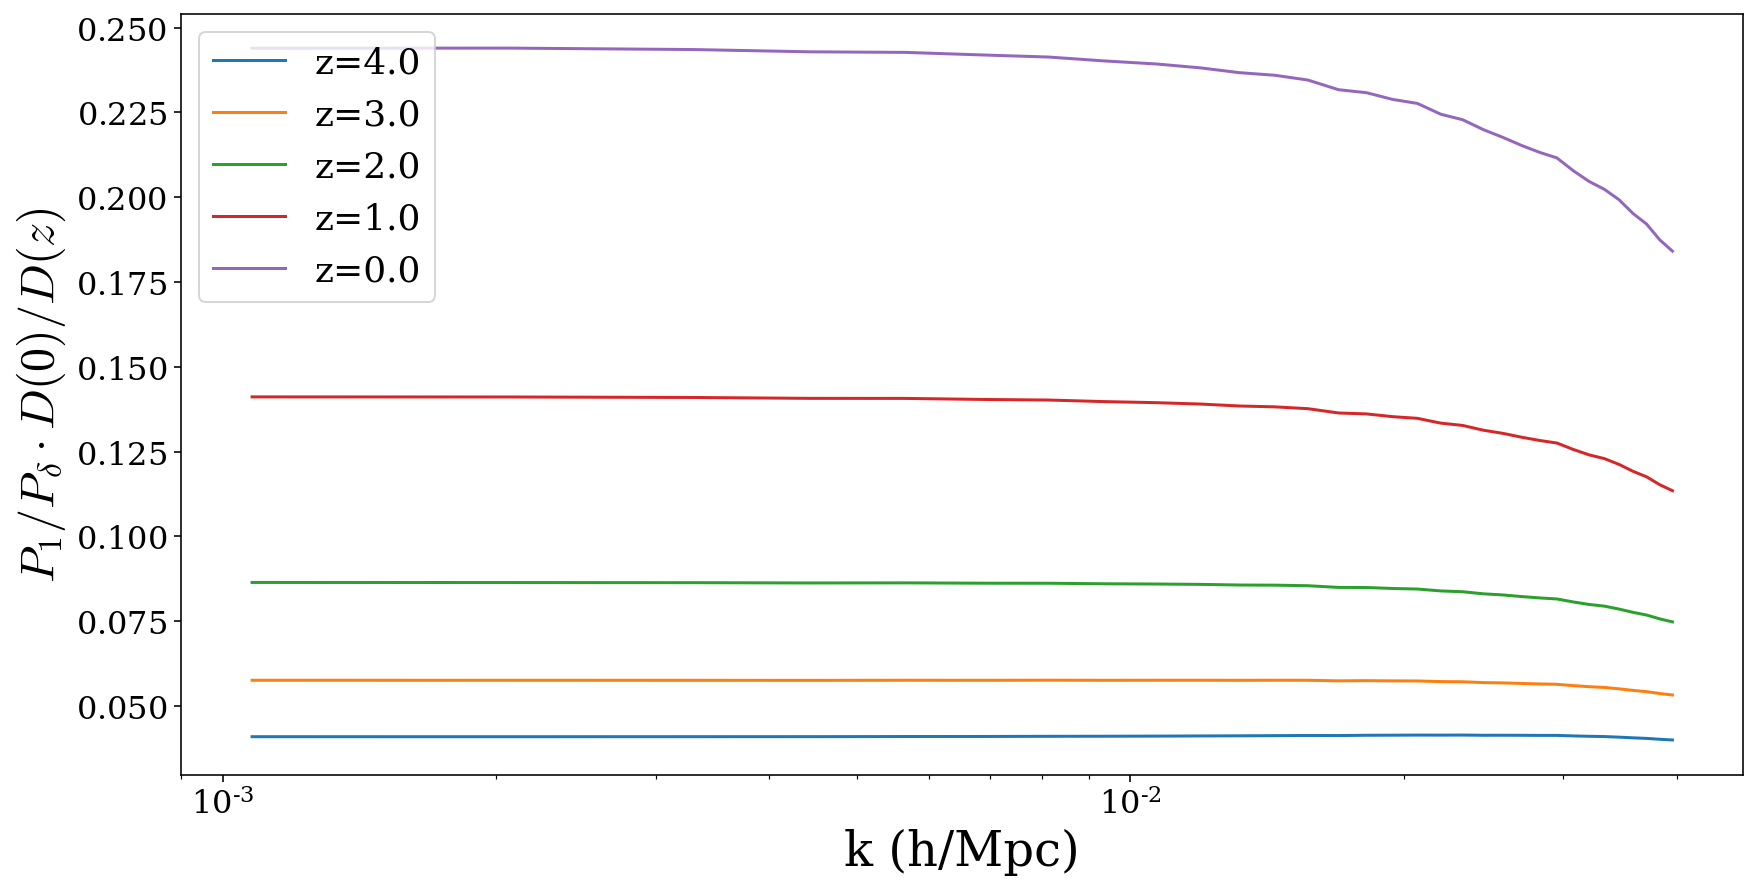

In [4]:
nc = 128
lpt_nc_factor = 1
pm_nc_factor = 1

Nc = [nc,nc,nc]
_q_size = Nc[0] * Nc[1] * Nc[2]
_q_strides = np.empty(3, dtype=int)
_q_strides[0] = Nc[1] * Nc[2]
_q_strides[1] = Nc[2]
_q_strides[2] = 1

def get_IQ_from_ID(ID):
    """
    integer version of the initial position q
    i.e. the lattice coordinates of the cells.
    """
    pabs = np.empty(3, dtype=int)
    for d in range(3):
        pabs[d] = ID / _q_strides[d]
        ID -= pabs[d] * _q_strides[d]
    return pabs

plt.figure(figsize=(14,7))
for z in [4, 3.5, 3, 2.5, 2.,1.5,1.,0.5,0.][::2]:
    a = 1./(1+z)
    sim = 'rfof_proc64_nc%d_size5000_nsteps60lin_ldr0_rcvfalse_fstnone_pnf%d_lnf%d_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_2048_rfofkdt_8/' % (nc,pm_nc_factor,lpt_nc_factor)
    prtl_snap = BigFileCatalog(mother + f'{sim}/snapshot_%.4f'%a, dataset='1')

    assert(prtl_snap.comm.Get_size() == 1)

    #import warnings
    #warnings.filterwarnings("ignore")
    #IQ = [get_IQ_from_ID(ID) for ID in prtl_snap['ID'].compute()]

    mesh_name = mother + sim
    mesh_k = BigFileMesh(mesh_name+'lineark/', dataset='LinearDensityK')
    mesh_kr = mesh_k.compute(mode='real')

    _delta = mesh_kr[::lpt_nc_factor, ::lpt_nc_factor, ::lpt_nc_factor]
    delta = _delta.flatten(order='C')  # unroll deltas, and subsample x2 from force grid  Try different deltas

    # get deltas based on particle ID for 3d case
    delta_at_particle_3d = delta[np.array(prtl_snap['ID'])]
    #delta_at_particle_3d = _delta[list(np.array(IQ).T)]

    #np.random.shuffle(delta_at_particle_3d)

    # add column to catalog for delta_at_particle
    prtl_snap['delta'] = delta_at_particle_3d

    # paint to 3d mesh
    Nmesh = 64
    mesh_particles = prtl_snap.to_mesh(window='tsc', Nmesh=Nmesh, compensated=True)
    mesh_density = prtl_snap.to_mesh(window='tsc', Nmesh=Nmesh, compensated=True, weight='delta')
    
    # compute power
    r_particles = FFTPower(mesh_particles, mode='1d') #, dk=0.005, kmin=0.01)
    r_density = FFTPower(mesh_density, mode='1d')
    #r_linear  = FFTPower(mesh_k, mode='1d')

    """
    # plot power
    plt.loglog(r_particles.power['k'], r_particles.power['power'].real, label='n')
    plt.loglog(r_density.power['k'], r_density.power['power'].real, label='density weighted')
    plt.legend()
    plt.xlabel('k (h/Mpc)')
    plt.ylabel('P')
    """
    
    Dratio = 1 #colcosmo.growthFactor(0) / colcosmo.growthFactor(z)

    # ratio
    plt.semilogx(r_particles.power['k'], r_particles.power['power'].real/r_density.power['power'].real * Dratio**2, label='z=%.1f'%z)
    #plt.semilogx(r_particles.power['k'][:int(Nmesh/2)], r_particles.power['power'].real/r_linear.power['power'].real[:int(Nmesh/2)], label='1/lin')
    plt.legend()

plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$P_1 / P_\delta \cdot D(0)/D(z)$')
plt.show()